In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
path = "Datasets/Soil Classification"
os.listdir(path)

['test', 'Train']

In [3]:
TRAIN_DIR = os.path.join(path, "Train")
VAL_DIR = os.path.join(path, "test")

In [4]:
BATCH_SIZE=16
IMG_SIZE= (224,224)

In [5]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    shuffle = True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode="categorical",
    shuffle = True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1213 files belonging to 4 classes.
Found 340 files belonging to 4 classes.


In [6]:
class_names = tuple(train_ds.class_names)
class_names

('Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil')

In [7]:
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.RandomRotation(20))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_data = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
validation_datat = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

In [8]:
for image_batch, label_batch in train_ds:
    break
image_batch.shape, label_batch.shape


(TensorShape([16, 224, 224, 3]), TensorShape([16, 4]))

In [9]:
model_handle = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 3,544,273
Trainable params: 4,008
Non-trainable params: 3,540,265
_________________________________________________________________


In [11]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(train_data,
          validation_data=validation_datat,
          epochs=30,
          steps_per_epoch=train_size,
          validation_steps= valid_size
         )

Epoch 1/30
76/76 [==============================] - 41s 330ms/step - loss: 1.5421 - accuracy: 0.4534 - val_loss: 1.4915 - val_accuracy: 0.4559
Epoch 2/30
76/76 [==============================] - 20s 264ms/step - loss: 1.0024 - accuracy: 0.6249 - val_loss: 1.1504 - val_accuracy: 0.5706
Epoch 3/30
76/76 [==============================] - 20s 265ms/step - loss: 0.7945 - accuracy: 0.7016 - val_loss: 0.9873 - val_accuracy: 0.6235
Epoch 4/30
76/76 [==============================] - 19s 245ms/step - loss: 0.6922 - accuracy: 0.7370 - val_loss: 0.8932 - val_accuracy: 0.6676
Epoch 5/30
76/76 [==============================] - 21s 272ms/step - loss: 0.5982 - accuracy: 0.7799 - val_loss: 0.8183 - val_accuracy: 0.6882
Epoch 6/30
76/76 [==============================] - 21s 279ms/step - loss: 0.5653 - accuracy: 0.7791 - val_loss: 0.7625 - val_accuracy: 0.7294
Epoch 7/30
76/76 [==============================] - 23s 292ms/step - loss: 0.5341 - accuracy: 0.8096 - val_loss: 0.7252 - val_accuracy: 0.7382

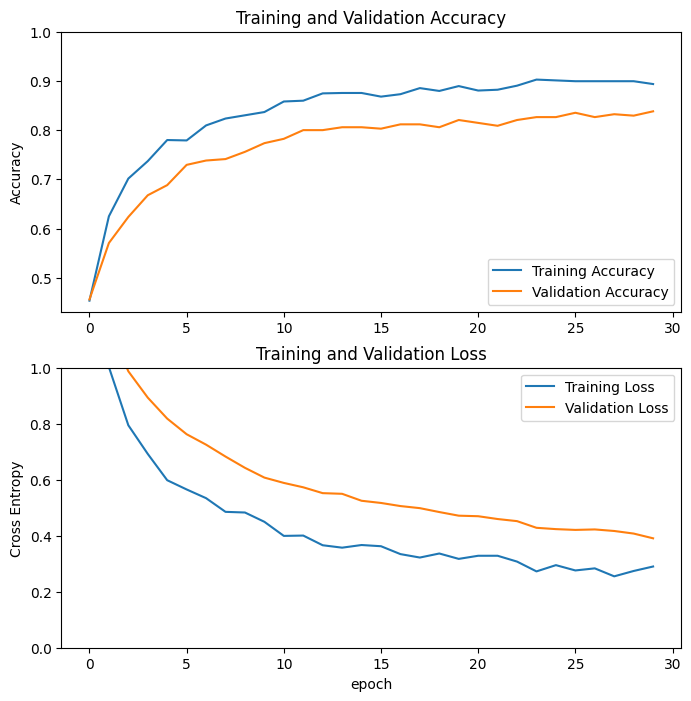

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')#
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
do_fine_tuning = True
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build((None,)+IMG_SIZE+(3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_1 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 3,544,273
Trainable params: 3,510,161
Non-trainable params: 34,112
_________________________________________________________________


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
               )
fine_tune_epochs = 30
initial_epochs =30
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_data,
                        validation_data=validation_datat,
                          steps_per_epoch=train_size,
                          validation_steps= valid_size,
                        epochs=total_epochs,
                        initial_epoch =  history.epoch[-1]
                        )

Epoch 30/60
76/76 [==============================] - 32s 310ms/step - loss: 1.4500 - accuracy: 0.5194 - val_loss: 1.4896 - val_accuracy: 0.4882
Epoch 31/60
76/76 [==============================] - 23s 293ms/step - loss: 0.9108 - accuracy: 0.7065 - val_loss: 1.0055 - val_accuracy: 0.6588
Epoch 32/60
76/76 [==============================] - 23s 301ms/step - loss: 0.8364 - accuracy: 0.7444 - val_loss: 0.9069 - val_accuracy: 0.6765
Epoch 33/60
76/76 [==============================] - 23s 301ms/step - loss: 0.6924 - accuracy: 0.7881 - val_loss: 0.8033 - val_accuracy: 0.7294
Epoch 34/60
76/76 [==============================] - 23s 300ms/step - loss: 0.6230 - accuracy: 0.8104 - val_loss: 0.7563 - val_accuracy: 0.7529
Epoch 35/60
76/76 [==============================] - 23s 301ms/step - loss: 0.5612 - accuracy: 0.8533 - val_loss: 0.7374 - val_accuracy: 0.7794
Epoch 36/60
76/76 [==============================] - 23s 301ms/step - loss: 0.5640 - accuracy: 0.8450 - val_loss: 0.6674 - val_accuracy:

In [15]:
import pickle
pickle.dump(model,open('soilclass.pkl','wb'))

INFO:tensorflow:Assets written to: ram://bc581cd8-f7f8-421a-b705-8ad222c82509/assets


INFO:tensorflow:Assets written to: ram://bc581cd8-f7f8-421a-b705-8ad222c82509/assets


In [17]:
new_model = tf.keras.models.load_model('soil.h5', custom_objects={'KerasLayer':hub.KerasLayer})

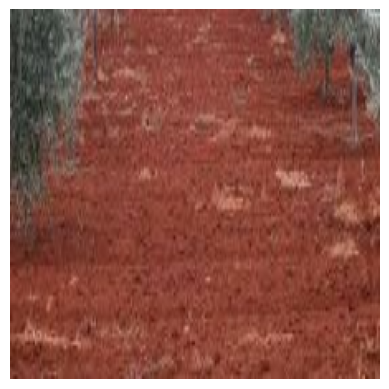

1/1 [==============================] - 1s 1s/step
True label: Red soil
Predicted label: Red soil


In [18]:
x, y = next(iter(validation_datat))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = new_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])